# Running an ESPy calculation
In this tutorial, we will run several calculations using the ```Elastic_stresses_py``` library:
1. We will run a calculation using the command line and configuration/inputs through text files. 
2. We will run a calculation modifying the inputs using the Python API. 

## Command line API
The basic usage of ```Elastic_stresses_py``` is through the command line.  We could first create an empty config file in the current directory (```.```) with: 

In [9]:
!elastic_stresses_config_writer.py .


Write a default config file for elastic_stresses_py. 
Writing file . /my_config.txt


You can check out the contents of this default config file. Remember that in a general case, the values and filepaths in this config file will need to be changed for your specific application. This file can be edited in a text editor.  For now, the values are good and we can move on to running the example calculation: 

In [10]:
!elastic_stresses_driver.py my_config.txt



Welcome to a simple forward modeling tool for calculating elastic displacements and coulomb stresses. 
Config file:  my_config.txt
Params(config_file='my_config.txt', input_file='M6.8_2014.intxt', aftershocks='CA_aftershocks_2014.txt', disp_points_file='CA_GPS_ll.txt', strain_file='', strike_num_receivers=10, dip_num_receivers=10, fixed_rake='', mu=30000000000.0, lame1=30000000000.0, B=0.0, alpha=0.6666666666666666, plot_stress=1, plot_grd_disp=1, outdir='Outputs/my_experiment/')
Reading source and receiver fault information from file M6.8_2014.intxt 
Reading displacement points from file CA_GPS_ll.txt 
Number of sources: 1
Moment Magnitude from Rectangular Fault Patches (assuming G=30.0GPa): 6.800000
Beginning stress calculation.
Number of sources: 1 
Number of receivers: 1 
Splitting 1 receiver faults into 100 subfaults each.
Computing synthetic grid of dispalcements
Number of disp_points: 105
Resolving stresses on receiver fault(s).
Resolving stresses on a horizontal profile.
Writ

Now you can check out the results. You calcualted a set of displacements and stresses from a hypothetical M6.8 earthquake at 16.4 km depth offshore northern California. The input format within ```M6.8_2014.intxt``` was the **Source_WC** format, which means a rectangular dislocation with dimensions calculated from Wells and Coppersmith (1994). 

## Python API

Now, let's say you wanted to create a different earthquake source: let's say you wanted to change the depth from 16 to 0.  Let's also say you wanted to change the output directory so you don't overwrite the original experiment results. We're going to do this by modifying the input and configuration parameter objects through the Python API that ```Elastic_stresses_py``` is actually using on the inside. 

We calculate in 4 steps: 
1. Configure
2. Input
3. Compute
4. Output

If you open the ```elastic_stresses_driver.py``` script, you'll see them expressed in this way: 
```
params = PyCoulomb.configure_calc.configure_stress_calculation(config_file);
[inputs, obs_disp_points, obs_strain_points] = PyCoulomb.input_values.read_inputs(params);
out_object = PyCoulomb.run_dc3d.do_stress_computation(params, inputs, obs_disp_points, obs_strain_points);
PyCoulomb.output_manager.produce_outputs(params, inputs, obs_disp_points, obs_strain_points, out_object);
```

In this API example, we're just running the steps one-by-one instead of all at once.  "Configure" and "Input" will be modified with modification functions.  "Compute" and "Output" will remain the same as usual. 

### Step 1: Configure
We begin by executing the normal "Configure" step: Reading a config file into an object type called ```Params```. 

In [1]:
from Elastic_stresses_py import PyCoulomb

# Create deafult Params object from the configuration file
default_params = PyCoulomb.configure_calc.configure_stress_calculation("my_config.txt");

Config file:  my_config.txt
Params(config_file='my_config.txt', input_file='M6.8_2014.intxt', aftershocks='CA_aftershocks_2014.txt', disp_points_file='CA_GPS_ll.txt', strain_file='', strike_num_receivers=10, dip_num_receivers=10, fixed_rake='', mu=30000000000.0, lame1=30000000000.0, B=0.0, alpha=0.6666666666666666, plot_stress=1, plot_grd_disp=1, outdir='Outputs/my_experiment/')


We next modify the Params object to direct our outputs into a different output folder, one that represents the modified geometry.  

In [2]:
# Modify the parameter object: Replace params.outdir with new outdir

print("Old experiment outdir:", default_params.outdir);
experiment_params = PyCoulomb.configure_calc.modify_params_object(default_params, outdir="Outputs/depth_0/");
print("New experiment outdir:", experiment_params.outdir);


Old experiment outdir: Outputs/my_experiment/
New experiment outdir: Outputs/depth_0/


### Step 2: Input
We then execute the normal input phase, reading an input file (```M6.8_2014.intxt```) into an object type called ```Input_object```. Optional objects for gps displacement points (```obs_disp_points```) and/or strain calculation points (not used here) are also created. 

In [3]:
# Read inputs like normal.  default_inputs = "Input_object"

[default_inputs, obs_disp_points, _] = PyCoulomb.input_values.read_inputs(experiment_params);

Reading source and receiver fault information from file M6.8_2014.intxt 
Reading displacement points from file CA_GPS_ll.txt 
Number of sources: 1
Moment Magnitude from Rectangular Fault Patches (assuming G=30.0GPa): 6.800000


Then we modify the source within the input object.  **NOTE: THIS IS STILL BEING DEVELOPED**.  It may be possible to create unrealistic scenarios (e.g., change the ratio of rtlat/reverse slip of a source but not the rake; change the top of a source but not the bottom, change the strike of a source but not the xstart/xfinish). Until this gets fully vetted, be very careful.

In [8]:
# Modify the single source in this object
original_source = default_inputs.source_object[0];  # extract the source
modified_source = PyCoulomb.configure_calc.modify_fault_object(original_source, top=0, bottom=12);  # adjust depth
inputs = PyCoulomb.configure_calc.modify_inputs_object(default_inputs, source_object=[modified_source]);  # package with new source

### Step 3 and Step 4: Compute, Output
Now we are ready to execute the calculation like normal. 

Beginning stress calculation.
Number of sources: 1 
Number of receivers: 1 
Splitting 1 receiver faults into 100 subfaults each.
Computing synthetic grid of dispalcements
Number of disp_points: 105
Resolving stresses on receiver fault(s).
Resolving stresses on a horizontal profile.
Writing file Outputs/depth_0/used_config.txt 
Writing Outputs/depth_0/ll_disps.txt 
Writing Outputs/depth_0/receiver_traces.txt
Writing outfile Outputs/depth_0/subfaulted.inp 
Reading aftershocks from file CA_aftershocks_2014.txt 
Writing file Outputs/depth_0/stresses_full.txt 
Making plot of shear stress on receiver fault patches: Outputs/depth_0/Stresses_shear.png. 
Making plot of normal stress on receiver fault patches: Outputs/depth_0/Stresses_normal.png. 
Making plot of coulomb stress on receiver fault patches: Outputs/depth_0/Stresses_coulomb.png. 
Reading aftershocks from file CA_aftershocks_2014.txt 
Reading aftershocks from file CA_aftershocks_2014.txt 
Reading aftershocks from file CA_aftershocks_2

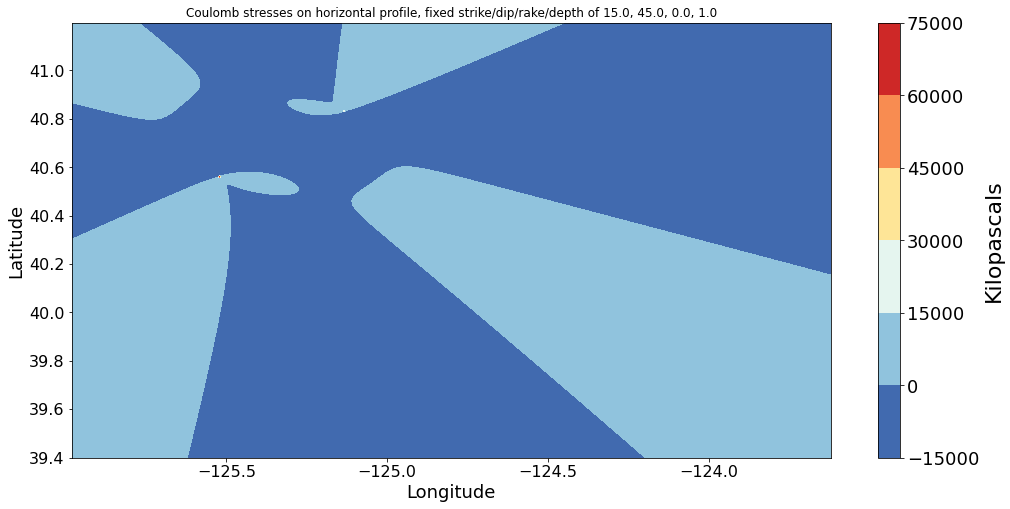

In [5]:
out_object = PyCoulomb.run_dc3d.do_stress_computation(experiment_params, inputs, obs_disp_points, ());
PyCoulomb.output_manager.produce_outputs(experiment_params, inputs, obs_disp_points, (), out_object);

Notice the differences between the plots in the first example and the second example.  The stresses on this profile are much higher at a depth of 1 km because the source is extremely close. You can see singularities at the corners because this calculation depth is very close to the depth of the fault corners. There are also larger displacements in both horizontal and vertical due to the reduced depth of the source. Some of the stresses on the receiver faults change sign due to the change in source depth. 